In [1]:
import os
from openslide import OpenSlide
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage import measure
from copy import deepcopy
import cv2
from matplotlib import pyplot as plt

In [2]:
# open both wsi and annotation map
wsi_src = os.path.expanduser(r'\\fatherserverdw\Q\research\images\CLUE\3D study\he\c1')
wsi_fn = '1C1.ndpi'
wsipath = os.path.join(wsi_src, wsi_fn)

#anno_src = os.path.expanduser(r'\\Users\kyuha\PycharmProjects\wsi_analysis\ashley')
#anno_fn = '1C1temp.png'
#annotation_map_path = os.path.join(anno_src, anno_fn)
wsi = OpenSlide(wsipath)
annotation = Image.open('1C1.png')  #40X resolution
iter_order = [2,10,5,4,6,11,7,9,8,12,3,1]

In [3]:
target_level = 2

In [4]:
rsf = wsi.level_downsamples[target_level]

In [5]:
target_dim = wsi.level_dimensions[target_level]

In [6]:
annotation_resized = annotation.resize(target_dim,resample=0) #this step is a bottleneck

In [ ]:
for classid in iter_order:
    annotation2crop = np.zeros_like(annotation_resized)
    #all annotation for the current class id
    annotation2crop[np.array(annotation_resized) == classid] = 1
    labeled_map = measure.label(annotation2crop)
    #regionprops has properties of the label
    regionprops = measure.regionprops(labeled_map)
    #bounboxes is a tuple, (min_row, min_col, max_row, max_col)
    boundboxes = [_.bbox for _ in regionprops]
    for objID, boundbox in enumerate(boundboxes[0:1]):
        #crop at the boundaries
        objmask = deepcopy(labeled_map)
        objmask[objmask != objID + 1] = 0
        objmask[objmask == objID + 1] = classid
        objmask = objmask[boundbox[0]:boundbox[2], boundbox[1]:boundbox[3]]
        h, w = boundbox[2] - boundbox[0], boundbox[3] - boundbox[1]
        #read cropped region
        imcrop = wsi.read_region(location=(round(boundbox[1]*rsf), round(boundbox[0]*rsf)), level=target_level, size=(w, h))
        imcrop_masked = imcrop * objmask[..., None]
        Image.fromarray((imcrop_masked).astype(np.uint8)).save('imcrop/class{}_obj{}.png'.format(classid, objID))
        Image.fromarray(objmask.astype(np.uint8)).save('mskcrop/classnew{}_obj{}.png'.format(classid, objID))



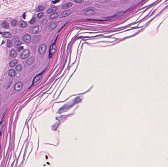

In [26]:
imcrop = wsi.read_region(location=(round(boundbox[1]*rsf), round(boundbox[0]*rsf)), level=target_level, size=(w, h))
imcrop

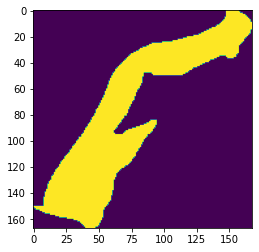

In [35]:
objmask[objmask == objID + 1] = 2
plt.imshow(objmask)

In [36]:
np.unique(objmask)

array([False,  True])

In [30]:
imcrop_masked =  imcrop * objmask[..., None]

In [ ]:

# iterate each class and each annotation object to make a crop
# for classid in iter_order:
#     annotation2crop = np.zeros_like(annotation)
#     #all annotation for the current class id
#     annotation2crop[np.array(annotation) == classid] = 1
#     labeled_map = measure.label(annotation2crop)
#     #regionprops has properties of the label
#     regionprops = measure.regionprops(labeled_map)
#     #bounboxes is a tuple, (min_row, min_col, max_row, max_col)
#     boundboxes = list()
#     for region in regionprops:
#         boundboxes.append(region.bbox)
#
#     for objID, boundbox in enumerate(boundboxes):
#         #crop at the boundaries
#         objmask = deepcopy(labeled_map)
#         objmask[objmask != objID + 1] = 0
#         objmask[objmask == objID + 1] = 1
#
#         objmask = objmask[boundbox[0]:boundbox[2], boundbox[1]:boundbox[3]]
#         h, w = boundbox[2] - boundbox[0], boundbox[3] - boundbox[1]
#
#         #read cropped region
#         imcrop = wsi.read_region(location=(boundbox[1], boundbox[0]), level=target_level, size=(w, h)).convert(
#             'RGB')  #use level 2, more zoomed in
#         imcrop = np.array(imcrop)
#
#         #create mask to crop out the extra space around the annotation
#         objmask = deepcopy(labeled_map)
#         objmask[objmask != 1] = 0
#         objmask[objmask == 1] = 1
#         #boundbox = [round(_/10) for _ in boundbox] #downsize by 10
#         objmask2 = objmask[boundbox[0]:boundbox[2],
#                    boundbox[1]:boundbox[3]]  #crop out the objmask2, typecast to integer
#
#         #enlarge objmask2 by 10 to get objmask3, take transpose of objmask3 to get objmask4
#         #new_shape = list(objmask2.shape)
#         #new_shape = [_*10 for _ in new_shape]
#         #objmask3 = cv2.resize(objmask2.astype(np.float),tuple(new_shape), interpolation = cv2.INTER_NEAREST)#NEAREST preserves pixel value
#
#         #find boundary of objmask3, use cv2 contour
#         #this gives you a list of bounding pixels\
#         #objmask3_img = Image.fromarray(objmask3.astype(np.uint8))
#
#         #objmask3_array = np.asarray(objmask3_img)
#
#         #this gives me a list of tuples
#         #contour, hierarchy = cv2.findContours(objmask3_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#
#         #loop through each pixel in bound_objmask3
#         #contour = np.array(contour)
#         #contour = contour.squeeze()
#
#         #for count,pix1 in enumerate(contour):
#         # while(count < len(contour) - 2): #is this right??
#         # for i in range(1, 5): #set n = 2 (split into two equal parts)
#         #   a = float((i) / 5)        # rescale 0 < i < n --> 0 < a < 1
#         #  x3 = (1 - a) * pix1[0] + a * contour[count+1][0]    # interpolate x coordinate
#         #   y3= (1 - a) * pix1[1] + a * contour[count+1][1]   # interpolate y coordinate
#         #   objmask3[int(x3),int(y3)] = 1 #add equidistant pixel to objmask3
#
#         objmask4 = np.dstack([objmask2.transpose()] * 3)  #change shape of objmask3
#
#         objmask2[objmask2 == 1] = classid  #Question: what does this do again?
#
#         #crop out the area outside the annotation using multiplication
#         imcrop_masked = np.multiply(objmask4, imcrop)
#
#         Image.fromarray((imcrop_masked).astype(np.uint8)).save('imcrop/class{}_obj{}.png'.format(classid, objID))
#         Image.fromarray(objmask2.astype(np.uint8)).save('mskcrop/classnew{}_obj{}.png'.format(classid, objID))

        #equidistant point
        #find bounding pixels, find point between neighboring pixels, add that pixel